In [ ]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)


In [ ]:
# %cd drive/My\ Drive/SIC\ -\ BigData/8.\ Project/

In [ ]:
# %ls

## Import packages

In [ ]:
# !pip install evaluate
# !pip install -U accelerate
!pip install datasets
# !pip install lxml
# !pip install -U pandas
# !pip install numpy
# !pip install transformers
# !pip install torch
# !pip install --upgrade pyarrow
# !pip install scikit-learn
# !pip install tensorboardX
# !pip install seaborn
# !pip install spacy
# !pip install xgboost
# !pip install beautifulsoup4

In [1]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
import spacy
import re
import string
import string
from bs4 import BeautifulSoup
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS
punctuations = string.punctuation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Prepare DataSet

In [3]:
# model_name = "bert-base-uncased"
# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(model_name)


ds = load_dataset('takala/financial_phrasebank', 'sentences_50agree',trust_remote_code=True)
df = ds['train'].to_pandas()
# df = df.drop_duplicates(subset='sentence')
# df.rename(columns={'sentence':'text'},inplace=True)

# 0 = negative
# 1 = neutral
# 2 = positive

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [4]:
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', None)

In [5]:
df.style.set_properties(**{'text-align': 'left'})

Output hidden; open in https://colab.research.google.com to view.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có DataFrame df
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

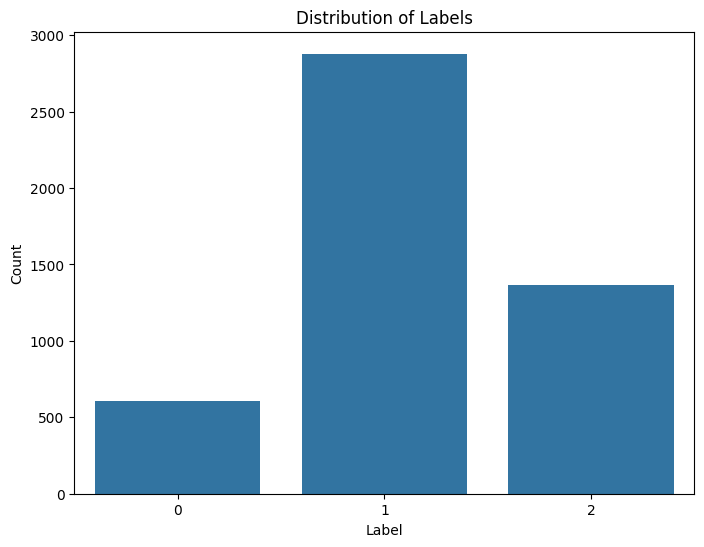

In [12]:
plt.figure(figsize=(8, 6))
sns.barplot(x='label', y='count', data=label_counts)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')

# Hiển thị biểu đồ
plt.show()

In [7]:
df.shape

(4846, 2)

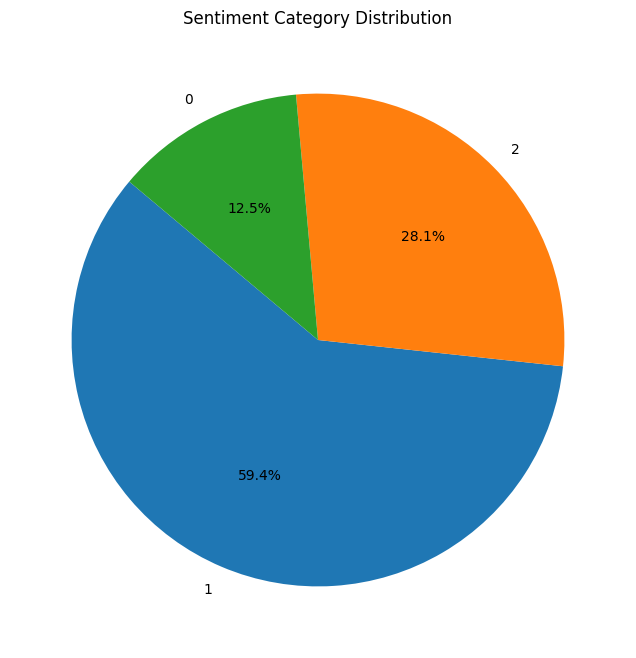

In [13]:
# Tạo biểu đồ pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts['count'], labels=label_counts['label'], autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Category Distribution')

# Hiển thị biểu đồ
plt.show()

In [10]:
print(df.columns)


Index(['sentence', 'label'], dtype='object')


In [ ]:
# Chuyển đổi ngược lại từ DataFrame sang Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [ ]:
dataset = DatasetDict()
dataset['train'] = train_dataset
dataset['val'] = val_dataset
dataset ['test'] = test_dataset

## Preprocessing DataSet

#### A: Clean 'text' columns
- python -m spacy download en_core_web_sm

**Creating our tokenizer function - lemmatized, lowercased; remove "-PRON"s, stop_words, punctuations**

In [ ]:
# nlp = English()
nlp = spacy.load('en_core_web_sm')
def clean_text(sentence):
    # # Parse HTML and extract plain text
    soup = BeautifulSoup(sentence+'<html>', "html.parser")
    sentence = re.sub(r'\[[^]]*\]', '', soup.get_text())

    # # # Remove links
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    return sentence

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
print(clean_text('$QCOM chart: Qualcomm Short 61.8% Retracement, Trendline and Resistance. https://t.co/2WQqh35KOY'))

$QCOM chart: Qualcomm Short 61.8% Retracement, Trendline and Resistance. 


**Clean_text**

In [ ]:
def preprocess_function(examples):
    examples['text'] = [clean_text(text) for text in examples['text']]
    return examples
cleaned_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
# Preprocess function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=64)

encoded_dataset = cleaned_dataset.map(tokenize, batched=True,batch_size=None)

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset = encoded_dataset.remove_columns('text')

In [ ]:
encoded_dataset['test']

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 970
})

## Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define Trainer parameters**

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy="epoch",
    disable_tqdm = False,
    greater_is_better=False,
    load_best_model_at_end = True,
    metric_for_best_model='eval_loss',
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['val'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=.0)],
    optimizers= (torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-5, betas=(0.9, 0.999)), None),
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.409719,0.838918,0.838288
2,0.514600,0.599302,0.850515,0.849891


TrainOutput(global_step=776, training_loss=0.45419946650868837, metrics={'train_runtime': 139.2806, 'train_samples_per_second': 222.572, 'train_steps_per_second': 27.857, 'total_flos': 203912898739200.0, 'train_loss': 0.45419946650868837, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4097190797328949,
 'eval_accuracy': 0.8389175257731959,
 'eval_f1': 0.8382878555488423,
 'eval_runtime': 2.8427,
 'eval_samples_per_second': 272.976,
 'eval_steps_per_second': 34.122,
 'epoch': 2.0}

In [ ]:
trainer.predict(encoded_dataset['test'])

PredictionOutput(predictions=array([[-3.2645352 ,  3.051129  ,  0.12808722],
       [-2.946536  ,  3.1705928 , -0.3433466 ],
       [-3.53656   ,  2.1208606 ,  1.3178064 ],
       ...,
       [-1.5521076 , -0.8273928 ,  2.473639  ],
       [-2.515949  , -0.14133784,  2.6722424 ],
       [-3.2701623 ,  3.0065494 ,  0.10533413]], dtype=float32), label_ids=array([1, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1,
       1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1,
       2, 1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 2, 0, 1, 2,
       0, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2,
       0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 2, 1, 2,